# Sample data exploitation: MLP for attitude estimation

Author: Anthony Kalaydjian

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import scipy

In [106]:
fname = r".\data\putty_2022-11-23T120907_outdir\tm_2022-11-23T120907_out.xlsx"

df1 = pd.DataFrame(pd.read_excel(fname, sheet_name="PIC_SENSORS", header = 0))
df2 = pd.DataFrame(pd.read_excel(fname, sheet_name="IMU", header = 0))

#removing missing data
missing_indices_2 = np.where(df2["tw_magn_x"]==-1)[0]
df2_raw = copy.deepcopy(df2.drop(missing_indices_2, axis=0))
df2_raw = df2_raw.reset_index(drop=True)

df1_raw = copy.deepcopy(df1)

## Interpolate the data to merge the 2 df given the timestamp

In [107]:
def special_merge(df_,df_sup_,colnames=None,delay=20):
    """
    interpolates df_sup's missing data wrt time
    """
    df, df_sup = copy.deepcopy(df_), copy.deepcopy(df_sup_)
    df.set_index(pd.to_datetime(df["timestamp"], unit='s'), inplace=True)
    df_sup.set_index(pd.to_datetime(df_sup["timestamp"], unit='s'), inplace=True)
    merged_df = pd.DataFrame(index=pd.Index.union(df.index, df_sup.index))
    merged_df = merged_df.join(df)
    if colnames is None:
        colnames = df_sup.columns.tolist()
    merged_df[colnames] = np.nan
    merged_df.update(df_sup[colnames])
    merged_df[colnames] = merged_df[colnames].interpolate(method='time')
    merged_df = merged_df.loc[df.index]
    closest_indexes = df_sup.index.searchsorted(df.index, side='left')
    closest_indexes[closest_indexes == len(df_sup)] = len(df_sup) - 1
    mask = abs(df_sup.index[closest_indexes] - df.index) <= pd.Timedelta(seconds=delay)
    merged_df.loc[~mask,colnames] = np.nan

    return merged_df 

In [108]:
df_raw = special_merge(df1_raw, df2_raw)
df_raw = df_raw.reset_index(drop=True)

C:\Users\antho\AppData\Local\Temp\ipykernel_11080\1356777139.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  merged_df[colnames] = merged_df[colnames].interpolate(method='time')


(Text(0.5, 0, 'x'), Text(0.5, 0.5, 'y'), Text(0.5, 0, 'z'))

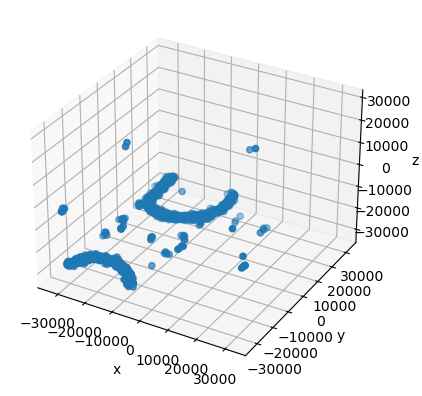

In [109]:
mag_x = df_raw["tw_magn_x"].values.tolist()
mag_y = df_raw["tw_magn_y"].values.tolist()
mag_z = df_raw["tw_magn_z"].values.tolist()

%matplotlib inline
ax = plt.axes(projection='3d')
ax.scatter3D(mag_x, mag_y, mag_z)
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")

## Fixing the discontinuity jump

In [110]:
mag_x, mag_y, mag_z = np.array(mag_x), np.array(mag_y), np.array(mag_z)
delta = np.max(mag_y) - np.min(mag_y)
mag_y[np.where(mag_y <= 0)] = mag_y[np.where(mag_y <= 0)] + delta

df_raw["tw_magn_y"] = mag_y

(Text(0.5, 0, 'x'), Text(0.5, 0.5, 'y'), Text(0.5, 0, 'z'))

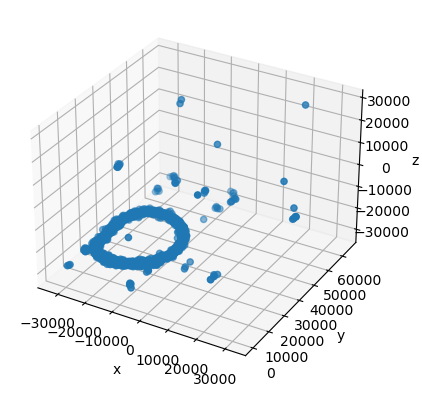

In [111]:
%matplotlib inline
ax = plt.axes(projection='3d')
ax.scatter3D(df_raw["tw_magn_x"].values.tolist(), df_raw["tw_magn_y"].values.tolist(), df_raw["tw_magn_z"].values.tolist())
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")

## Removing aberrant points

In [112]:
ab1 = np.where(mag_z > -20000)[0]
ab2 = np.where(mag_y > 45000)[0]
ab3 = np.where(mag_y < 10000)[0]
ab4 = np.where(mag_x>=0)[0]
ab5 = np.intersect1d(np.intersect1d(np.where(mag_y < 15000), np.where(mag_z > -28000)), np.where(mag_x < -25000))
ab6 = np.intersect1d(np.intersect1d(
            np.intersect1d(np.where(mag_y < 25000), np.where(mag_y < 25000)),
            np.intersect1d(np.where(mag_y > 20000), np.where(mag_x < -9000))), np.where(mag_x > -11000))
ab7 = np.intersect1d(np.where(mag_x > -10000), np.where(mag_y < 12000))

aberrant_points = np.concatenate([ab1, ab2, ab3, ab4, ab5, ab6, ab7], axis=0)
aberrant_points = np.unique(aberrant_points)

df = df_raw.drop(aberrant_points, axis=0)
df = df.reset_index(drop=True)

(Text(0.5, 0, 'x'), Text(0.5, 0.5, 'y'), Text(0.5, 0, 'z'))

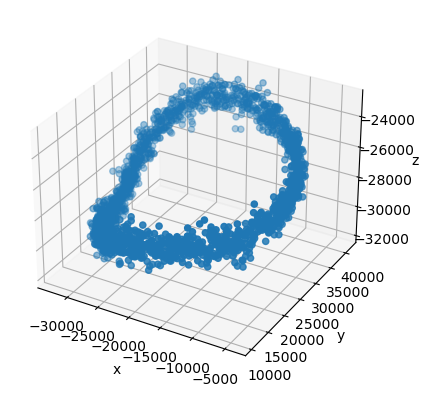

In [113]:
%matplotlib inline
ax = plt.axes(projection='3d')
ax.scatter3D(df["tw_magn_x"], df["tw_magn_y"], df["tw_magn_z"])
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")

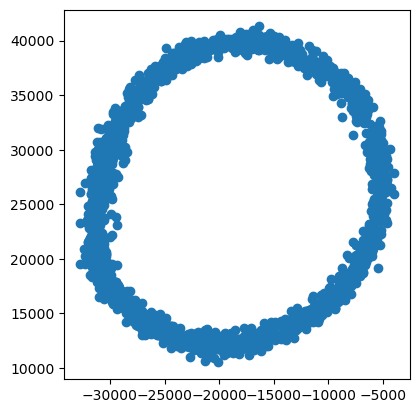

In [114]:
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.scatter(df["tw_magn_x"], df["tw_magn_y"])

## Removing useless data and scaling the dataset

In [115]:
useless_columns = ["time_rx", "src_rx", "lat_rx", "lon_rx", "n_epoch", "timestamp",
                   "service", "subservice", "nsample", "acq_mode", "filter_tempo",
                   "last_anomaly_code", "last_start_source", "recieved_i2c_tc",
                   "processed_i2c_tc", "tw_temp", "tw_state", "tw_res_reason"]
df_cleaned = df.drop(useless_columns, axis=1)

(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'))

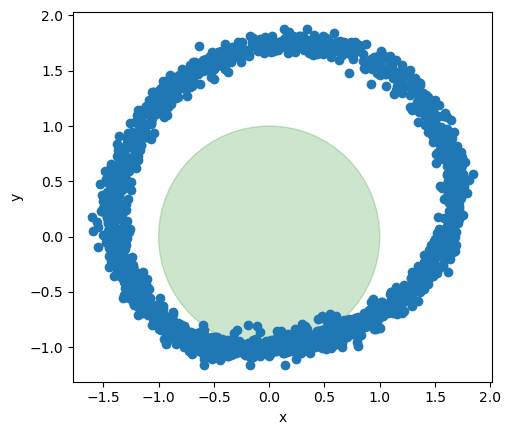

In [116]:
mean =  df_cleaned.mean(axis=0)
std =   df_cleaned.std(axis=0)

df_scaled = (df_cleaned - mean)/std

%matplotlib inline
fig, ax = plt.subplots()
#drawing unit circle
circle = plt.Circle((0, 0), 1, color='g', alpha=0.2)
ax.add_patch(circle)
ax.set_aspect('equal', adjustable='box')

plt.scatter(df_scaled["tw_magn_y"], df_scaled["tw_magn_x"])
plt.xlabel("x"), plt.ylabel("y")

## Calibrating magnetometer data

In [117]:
"""Executing the magnetometer calibration script"""
execfile("./my_mag_calib.py")

In [118]:
res = mag_calib(df_scaled)

Text(0, 0.5, 'y')

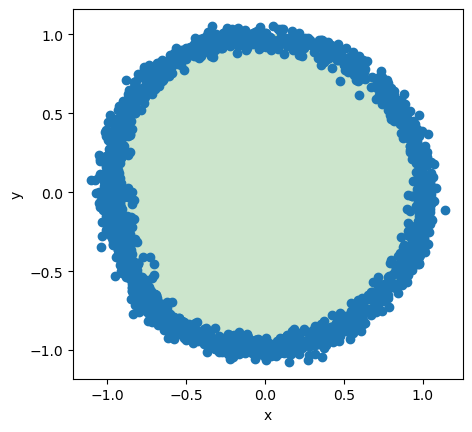

In [119]:
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, color='g', alpha=0.2)
ax.add_patch(circle)
ax.set_aspect('equal', adjustable='box')
plt.scatter(res[0], res[1])
plt.xlabel("x")
plt.ylabel("y")

## Calculating the angle of rotation

(Text(0.5, 0, 'step'), Text(0, 0.5, '$\\theta$'))

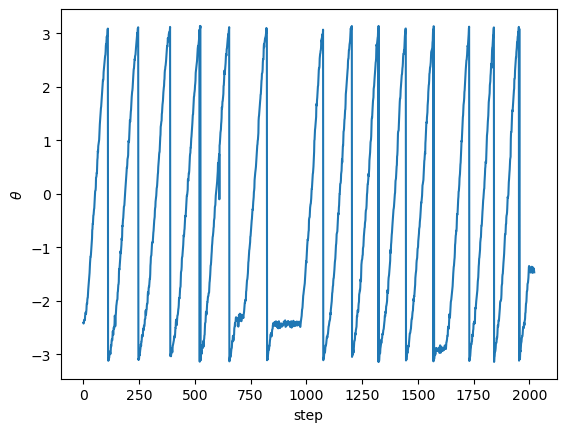

In [120]:
theta = np.arctan2(res[1], res[0])
df_scaled["theta"] = theta

plt.plot(df_scaled["theta"])
plt.xlabel("step"), plt.ylabel("$\\theta$")

In [121]:
#Only keeping the first 1900 samples, as the last ones have problems
df_scaled = df_scaled.iloc[0:1901, :]
df_cleaned = df_cleaned.iloc[0:1901,:]

# Multivariate analysis

Text(0.5, 1.0, 'Correlation matrix')

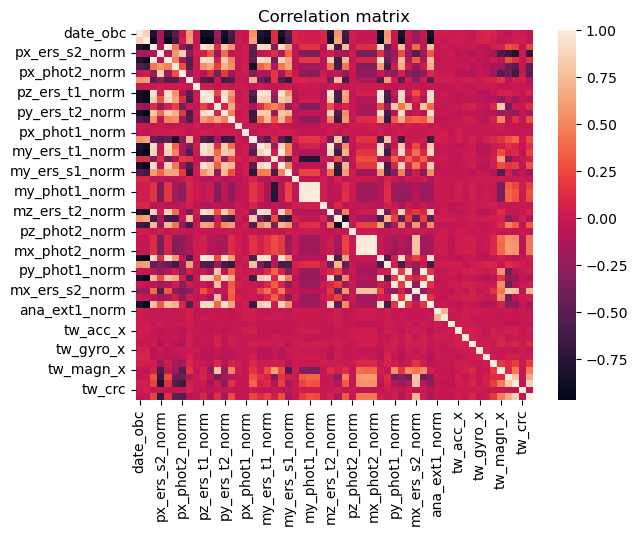

In [122]:
"""correlation matrix"""
%matplotlib inline
sns.heatmap(df_scaled.corr())
plt.title("Correlation matrix")

Text(0.5, 1.0, 'Correlation matrix of highly correlated variables')

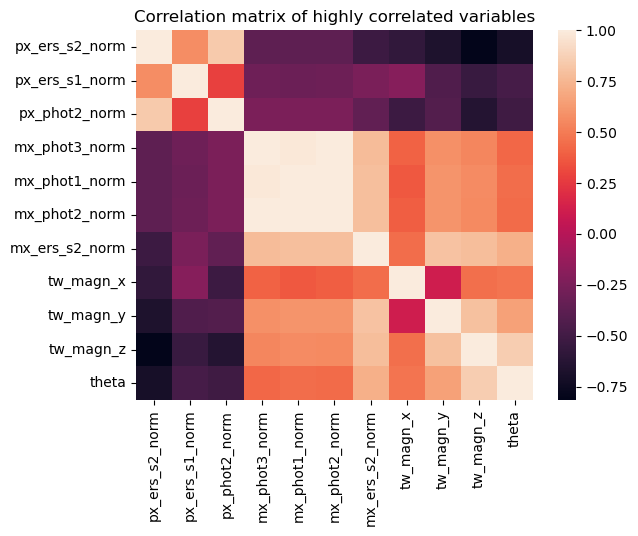

In [123]:
"""Correlation matrix of highly correlated variables"""
theta_corr = df_scaled.corr()["theta"]
high_corr = theta_corr.where(np.abs(theta_corr) > 0.4).dropna().index
df_corr = df_scaled[high_corr]
sns.heatmap(df_corr.corr())
plt.title("Correlation matrix of highly correlated variables")

In [124]:
%
"""correlogram"""
df_trimmed = df_scaled[high_corr]
correlogram = sns.pairplot(df_trimmed)
correlogram.fig.suptitle("Correlogram of highly correlated variables")

UsageError: Line magic function `%` not found.


# MLP on encoded angle

In [125]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import tqdm
import copy

In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [127]:
y_columns = ["theta"]
X_removed_columns = ["theta", "tw_magn_x", "tw_magn_y", "tw_magn_z", "date_obc", 'tw_acc_x', 'tw_acc_y', 'tw_acc_z']

X_list = df_scaled.drop(X_removed_columns, axis=1)
y_list = df_scaled[y_columns]

In [128]:
np.random.seed(seed=27)
# train-test split for model evaluation
X_train, X_temp, y_train, y_temp = train_test_split(X_list, y_list, train_size=0.7, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.5, shuffle=True)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test.to_numpy(), dtype=torch.float32).to(device)
X_val   = torch.tensor(X_val.to_numpy(), dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val.to_numpy(), dtype=torch.float32).to(device)

In [129]:
y_train = torch.hstack([torch.sin(y_train), torch.cos(y_train)])
y_test  = torch.hstack([torch.sin(y_test), torch.cos(y_test)])
y_val   = torch.hstack([torch.sin(y_val), torch.cos(y_val)])

In [130]:
def encoding_loss(output, input, loss_fn=nn.MSELoss()):
    lbda = 1
    penalty = lbda*torch.mean((1 - torch.linalg.norm(output, dim=1))**2)

    return loss_fn(output, input) + penalty

In [131]:
def choose_angle(row):
    """
    Selection of the element with lowest absolute value
    """
    n0 = np.abs(row[0])
    n1 = np.abs(row[1])
    n2 = np.abs(row[2])

    n = np.array([n0, n1, n2])
    return np.where(n==np.min(n))

def fixed_angle_error(angle, angle_pred, tnsr=True):
    """
    fixing the angle discontinuity between 0° and 360°
    """
    if tnsr:
        np_angle = angle.detach().cpu().numpy()
        np_angle_pred = angle_pred.detach().cpu().numpy()
    else:
        np_angle = angle
        np_angle_pred = angle_pred

    np_angle_error = (np_angle - np_angle_pred)*180/np.pi

    angle_error_stacked = np.hstack([np_angle_error.reshape((-1,1)), (np_angle_error - 360).reshape((-1,1)), (np_angle_error + 360).reshape((-1,1))])

    angle_index = np.apply_along_axis(func1d=choose_angle, arr=angle_error_stacked, axis=1).squeeze()
    fixed_error = np.apply_along_axis(func1d = lambda i: angle_error_stacked[i, angle_index[i]], arr=np.arange(len(angle_index)), axis=0)

    return fixed_error

Error: 0.00
generalisation Error: 0.004496968351304531
validation Error: 0.00677545415237546
Chosen epoch:       74
test error:         2.7781941890716553°
validation error:   3.6151325702667236°


(Text(0.5, 0, 'epoch'), Text(0, 0.5, 'error'))

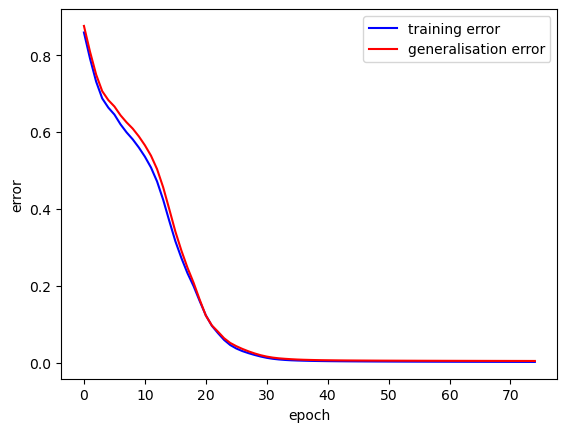

In [132]:
torch.manual_seed(92)

input_size  = X_train.shape[1]
output_size = y_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_size, 92),
    nn.ReLU(),
    nn.Linear(92, 32),
    nn.ReLU(),
    nn.Linear(32, 28),
    nn.ReLU(),
    nn.Linear(28, 10),
    nn.ReLU(),
    nn.Linear(10, output_size)
).to(device)

# loss function and optimizer
loss_fn = encoding_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 75  # number of epochs to run
batch_size = 350  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_error = np.inf   # init to infinity
best_weights = None
training_error_list = []
generalisation_error_list = []
min_epoch = 0

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(error=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    #training error
    training_error_list.append(float(loss_fn(model(X_train), y_train)))
    #generalisation error
    y_pred = model(X_test)
    generalisation_error = loss_fn(y_pred, y_test)
    generalisation_error = float(generalisation_error)
    generalisation_error_list.append(generalisation_error)
    if generalisation_error < best_error:
        best_error = generalisation_error
        best_weights = copy.deepcopy(model.state_dict())
        min_epoch = epoch

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("Error: %.2f" % best_error)

test_error  = loss_fn(model(X_test), y_test)

y_pred = model(X_val)
val_error   = loss_fn(y_pred, y_val)

print(f"generalisation Error: {test_error}")
print(f"validation Error: {val_error}")

y_train_pred = model(X_train)
train_angle         = torch.atan2(y_train[:,0], y_train[:,1])
train_angle_pred    = torch.atan2(y_train_pred[:,0], y_train_pred[:,1])
train_angle_error   = torch.abs(train_angle - train_angle_pred)

fixed_train_error = fixed_angle_error(train_angle, train_angle_pred)

angle       = torch.atan2(y_val[:,0], y_val[:,1])
angle_pred  = torch.atan2(y_pred[:,0], y_pred[:,1])
angle_error = torch.abs(angle - angle_pred)

fixed_error = fixed_angle_error(angle, angle_pred)

print(f"Chosen epoch:       {min_epoch}")
print(f"test error:         {np.std(fixed_train_error)}°")
print(f"validation error:   {np.std(fixed_error)}°")

plt.plot(training_error_list, c="blue")
plt.plot(generalisation_error_list, c="red")
plt.legend(["training error", "generalisation error"])
plt.xlabel("epoch"), plt.ylabel("error")

#plt.savefig("figs/MLP_training")

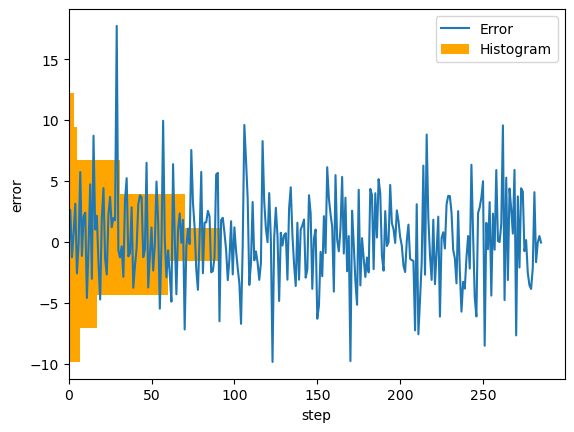

In [133]:
plt.plot(fixed_error)
plt.hist(fixed_error, orientation="horizontal", color="orange")
plt.xlabel("step"), plt.ylabel("error")
plt.legend(["Error", "Histogram"])

In [134]:
np_mean = np.mean(np.abs(fixed_error))
np_std  = np.std(fixed_error)

print(f"MEAN error  :{'%.2f' % np_mean}°")
print(f"STD         :{'%.2f' % np_std}°")

MEAN error  :2.79°
STD         :3.62°


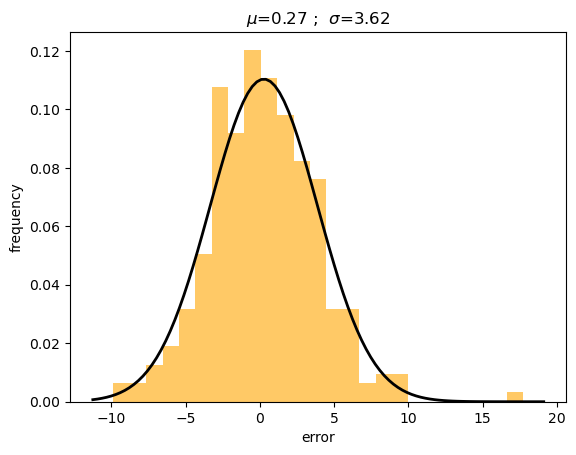

In [135]:
# Fitting normal distribution
mu, std = scipy.stats.norm.fit(fixed_error) 
  
# Plot the histogram.
plt.hist(fixed_error, bins=25, density=True, alpha=0.6, color="orange")

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
plt.title("$\mu$={:.2f} ;  $\sigma$={:.2f}".format(mu, std))

plt.xlabel("error"), plt.ylabel("frequency")
plt.show()

# TRIAD Method

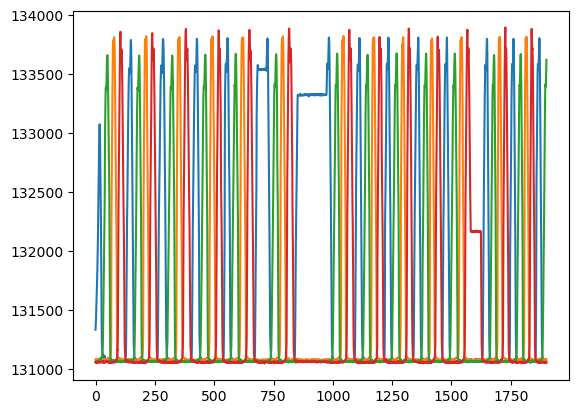

In [136]:
flux_px = df_cleaned["px_phot2_norm"].to_numpy()
flux_mx = df_cleaned["mx_phot3_norm"].to_numpy()
flux_py = df_cleaned["py_phot1_norm"].to_numpy()
flux_my = df_cleaned["my_phot1_norm"].to_numpy()

plt.plot(flux_px)
plt.plot(flux_mx)
plt.plot(flux_py)
plt.plot(flux_my)

#plt.savefig("figs/triad_different_photodiodes")

In [137]:
def triad_angle(df=df_cleaned):
    flux_px = df["px_phot2_norm"].to_numpy()
    flux_mx = df["mx_phot3_norm"].to_numpy()
    flux_py = df["py_phot1_norm"].to_numpy()
    flux_my = df["my_phot1_norm"].to_numpy()

    coord_x = flux_px - flux_mx
    coord_y = flux_py - flux_my

    angle_list = np.arctan2(coord_y, coord_x)

    return angle_list

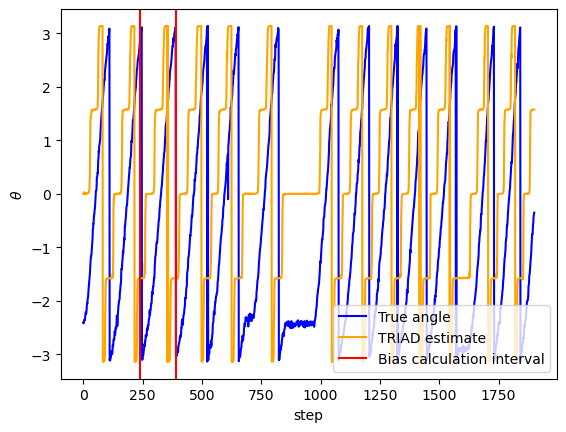

In [138]:
triad_estimate  = triad_angle(df_cleaned)
true_angle      = df_scaled["theta"]

plt.plot(true_angle, c="blue")
plt.plot(triad_estimate, c="orange")
plt.xlabel("step"), plt.ylabel("$\\theta$")

x_bias_min = 240
x_bias_max = 390
plt.axvline(x=x_bias_min, c='r')
plt.axvline(x=x_bias_max, c='r')

plt.legend(["True angle", "TRIAD estimate", "Bias calculation interval"], loc="lower right")
#plt.savefig(fname="figs/triad_raw_shifted")

Here we see that their is indeed a bias between the direction given by the magnetometer and the one that is estimated by the triad method (phase shift). This can be resolved by shifting the triad estimate by the right bias, found by minimising a certain cost function

In [139]:
def bias_optimizer(x, true_angle, triad_estimate):
    s_term = np.abs(np.sin(x + triad_estimate - true_angle))
    c_term = np.abs(1 - np.cos(x + triad_estimate - true_angle))

    return np.mean(s_term + c_term)

def bias_finding(true_angle, triad_estimate):
    solution = scipy.optimize.minimize(lambda x: bias_optimizer(x, true_angle, triad_estimate), x0=np.array([0]))
    return solution

In [140]:
#computing the bias a clean interval
bias_term = bias_finding(true_angle[x_bias_min:x_bias_max], triad_estimate[x_bias_min:x_bias_max]).x[0]
bias_term

-1.8713841174662966

In [141]:
#shifting the bias corrected angle back to the right domain
triad_angle = np.arctan2(np.sin(triad_estimate + bias_term), np.cos(triad_estimate + bias_term))

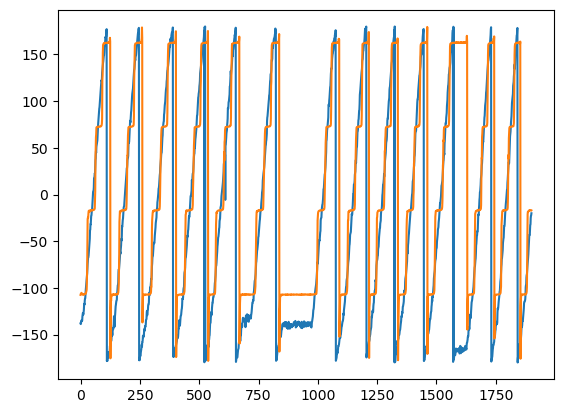

In [142]:
%matplotlib inline
plt.plot(true_angle*180/np.pi)
plt.plot(triad_angle*180/np.pi)
#plt.savefig("figs/triad_shift_corrected")

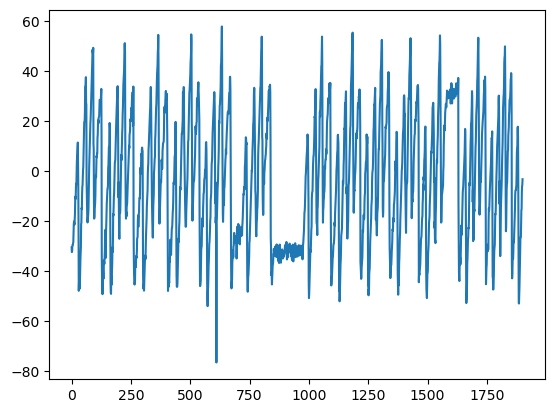

In [143]:
raw_fixed_error = fixed_angle_error(true_angle.values, triad_angle, tnsr=False)
plt.plot(raw_fixed_error)
#plt.savefig("figs/triad_error")

In [144]:
triad_mu, triad_std = np.mean(raw_fixed_error), np.std(raw_fixed_error)

print(f"error mean  : {triad_mu}°")
print(f"error STD   : {triad_std}°")

error mean  : -3.3252571938173827°
error STD   : 25.79441032721231°


Text(0.5, 1.0, '$\\mu$=-3.33 ;  $\\sigma$=25.79')

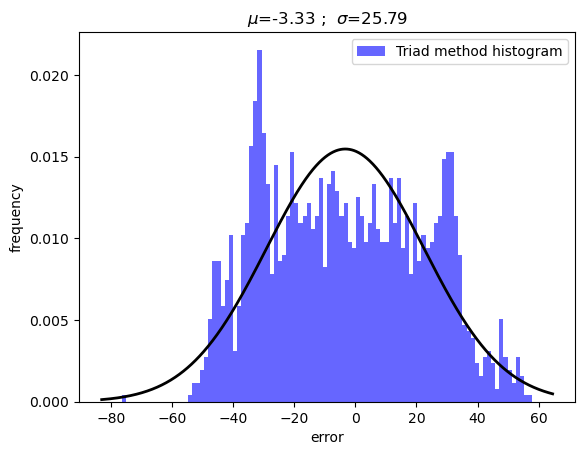

In [145]:
histo = plt.hist(raw_fixed_error, bins=100, density=True, alpha=0.6, color='b')
plt.legend(["Triad method histogram"])
plt.title("TRIAD method histogram")
plt.xlabel("error"), plt.ylabel("frequency")

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = scipy.stats.norm.pdf(x, triad_mu, triad_std)

plt.plot(x, p, 'k', linewidth=2)
plt.title("$\mu$={:.2f} ;  $\sigma$={:.2f}".format(triad_mu, triad_std))
#plt.savefig("figs/triad_error_hist")